# **FEATURE ENGINEERING**

## **IMPORTS/TRAIN.CSV**

In [66]:
# Import Required Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [67]:
train = pd.read_csv('application_train.csv')
print('Num of columns: ', train.shape[1])
print('Num of rows: ', train.shape[0])

Num of columns:  122
Num of rows:  307511


## **INITIAL EDA**

0    178584
1     14536
Name: TARGET, dtype: int64


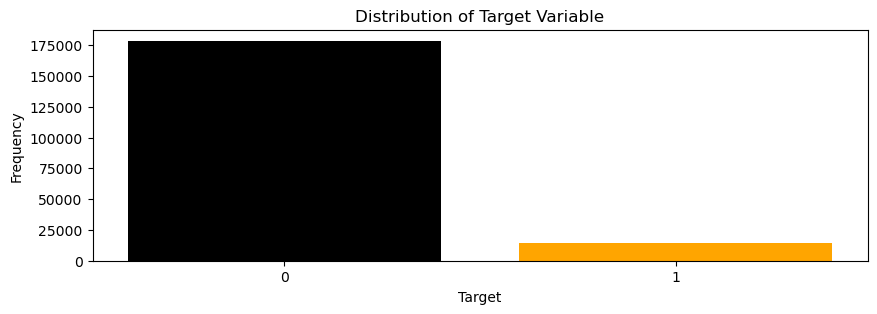

In [147]:
counts = train['TARGET'].value_counts() # collect the counts of 0's and 1's
print(counts)
fig, ax = plt.subplots(figsize=(10,3))
ax.bar(counts.index, counts.values, color=['black', 'orange'])
ax.set_xticks([0,1])
ax.set_xlabel('Target')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Variable')
plt.show()

## **TRAIN.CSV PREPROCESSING**

In [69]:
# Split the train data into manageable sets by dtype
target = train['TARGET']
id_curr = train['SK_ID_CURR']
int_features = train.select_dtypes(include='int64')
float_features = train.select_dtypes(include='float64')
object_features = train.select_dtypes(include='object')

### **OBJECT FEATURES**
We will preprocess each object feature individually, depending on which encoding method seems viable for the column.

In [70]:
# Remove Features with too many NA's
drops = ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'WEEKDAY_APPR_PROCESS_START']
object_features = object_features.drop(drops, axis=1)

In [71]:
# define a function to count na's in each column and return them neatly. 

def count_na(df):
    # Count NA values in features
    print(f'Amount of NA\'s in each column: ')
    print('-'*50)
    count = 0
    for col in df:
        print(f'{count}. {col}: {df[col].isna().sum()}')
        count += 1 
    print('-'*50, '\n')
    return f'Amount of Columns: {count}'

count_na(object_features)
# we will return to this function after preprocessing viable object features

Amount of NA's in each column: 
--------------------------------------------------
0. NAME_CONTRACT_TYPE: 0
1. CODE_GENDER: 0
2. FLAG_OWN_CAR: 0
3. FLAG_OWN_REALTY: 0
4. NAME_TYPE_SUITE: 1292
5. NAME_INCOME_TYPE: 0
6. NAME_EDUCATION_TYPE: 0
7. NAME_FAMILY_STATUS: 0
8. NAME_HOUSING_TYPE: 0
9. OCCUPATION_TYPE: 96391
10. ORGANIZATION_TYPE: 0
-------------------------------------------------- 



'Amount of Columns: 11'

**We will assume that an 'NaN' values for 'OCCUPATION_TYPE' and 'NAME_TYPE_SUITE' hold significance in relation to default. The next step is to determine which encoding method will be used on each feature. Some of the features, like 'CODE_GENDER', 'FLAG_OWN_CAR', etc. will simply require an applied map to change non-numeric binary labels to 1's and 0's.**

In [72]:
def weight_of_evidence_encode(df, column_name, label):
    """
    Pass train df, name of column to be encoded, and target column.
    """
    epsilon = 1e-6
    pos = df.groupby(column_name)[label].mean() + epsilon
    neg = 1 - pos + epsilon
    weight_of_evidence = np.log(pos / neg)
    
    woe_dict = weight_of_evidence.to_dict()
    woe_encoded = df[column_name].map(woe_dict)
    
    return woe_encoded


In [73]:
# One-Hot encoding was unsuccessful the first time around, however, this
# function will remain in the notebok in case it is needed later
def one_hot_encode(dataframe, column, drop_first=True):
    """
    One hot encode specified column
    """
    return pd.get_dummies(dataframe, columns=[column])


#### Occupation Feature

Weight of Evidence Encoding: 
 - Natural log of the ratio of prob (default) : prob (pay back) for each unique value of the column

In [74]:

object_features['TARGET'] = target
object_features['OCCUPATION_TYPE'].fillna('not submitted', inplace=True)
object_features['OCCUPATION_TYPE'] = weight_of_evidence_encode(
    object_features, 'OCCUPATION_TYPE', 'TARGET'
)


#### Binary String Features

In [75]:
# fill missing in gender with M
object_features['CODE_GENDER'] = object_features['CODE_GENDER'].fillna('M')

# map ('M' and 'F') and ('Y' and 'N')to 1 and 0, respectively. 
mapping = {'Y': 1, 'N': 0, 'M': 1, 'F': 0, 'Cash loans': 0, 'Revolving loans': 1}
string_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
object_features[string_cols] = object_features[string_cols].applymap(mapping.get)

In [76]:
object_features['CODE_GENDER'] = object_features['CODE_GENDER'].fillna(object_features['CODE_GENDER'].mode().iloc[0])

#### NAME_TYPE_SUITE

In [77]:

# fill missing values in the NAME_TYPE_SUITE column with 'not submitted'
object_features['NAME_TYPE_SUITE'] = object_features['NAME_TYPE_SUITE'].fillna('not submitted')

# check the unique values in the NAME_TYPE_SUITE column
print(object_features['NAME_TYPE_SUITE'].unique())


['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A'
 'not submitted' 'Other_B' 'Group of people']


In [78]:
# group by 'NAME_TYPE_SUITE' and count the number of occurrences of 0's and 1's in the 'TARGET' column
counts = object_features.groupby(['NAME_TYPE_SUITE', 'TARGET']).size().unstack(fill_value=0)
counts['posneg_ratio'] = counts[1] / counts[0]
counts

TARGET,0,1,posneg_ratio
NAME_TYPE_SUITE,,,
Children,3026,241,0.079643
Family,37140,3009,0.081018
Group of people,248,23,0.092742
Other_A,790,76,0.096203
Other_B,1596,174,0.109023
"Spouse, partner",10475,895,0.085442
Unaccompanied,228189,20337,0.089123
not submitted,1222,70,0.057283


Referring back to the EDA section, the total weight of positive cases in the dataset is 0.08782

In [79]:
# bin the 'NAME_TYPE_SUITE' values into three separate bins of nearest values

suite_mapping = {
    'Children': 0.079643,
    'Family': 0.081018,
    'Group of people': 0.092742,
    'Other_A': 0.096203,
    'Other_B': 0.109023,
    'Spouse, partner': 0.085442,
    'Unaccompanied': 0.089123,
    'not submitted': 0.057283,
}

bins = [0, 0.082, 0.09, 0.11]
labels = [0, 1, 2]
object_features['NAME_TYPE_SUITE'] = object_features['NAME_TYPE_SUITE'].map(suite_mapping)
object_features['NAME_TYPE_SUITE_BINNED'] = pd.cut(object_features['NAME_TYPE_SUITE'], bins=bins, labels=labels)
object_features.drop('NAME_TYPE_SUITE', axis=1, inplace=True)

#### Organization Type

Once again - given the large amount of unique values in this column - it will be Weight of Evidence encoded.

In [80]:
object_features['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

In [81]:
object_features['ORGANIZATION_TYPE'] = weight_of_evidence_encode(
    object_features, 'ORGANIZATION_TYPE', 'TARGET'
)

#### Housing Type

In [82]:
object_features['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [83]:
object_features['NAME_HOUSING_TYPE'] =  weight_of_evidence_encode(
    object_features, 'NAME_HOUSING_TYPE', 'TARGET'
)

#### Income Type

In [84]:
object_features['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [85]:
object_features['NAME_INCOME_TYPE'] = weight_of_evidence_encode(
    object_features, 'NAME_INCOME_TYPE', 'TARGET'
)

#### Education

In [86]:
object_features['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [87]:
# Encode the education type feature by frequency. 
# Thesis is that model will pick up on infrequent education levels
# in combination with values of the other features to determine target. 
encoder = LabelEncoder()
encoder.fit(object_features['NAME_EDUCATION_TYPE'])
object_features['NAME_EDUCATION_TYPE'] = encoder.transform(
    object_features['NAME_EDUCATION_TYPE'])  


#### Fam Status

In [88]:
object_features['NAME_FAMILY_STATUS'].unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

<AxesSubplot: xlabel='NAME_FAMILY_STATUS', ylabel='TARGET'>

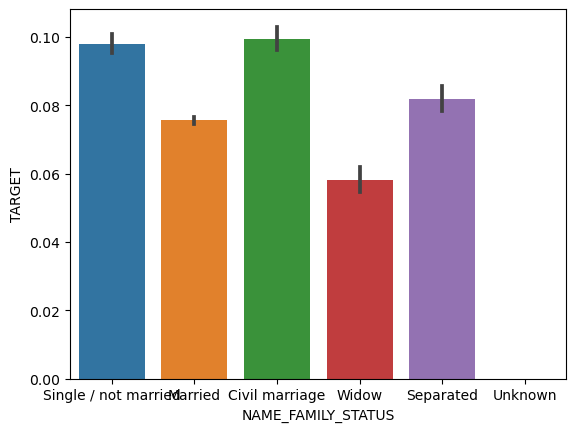

In [89]:
sns.barplot(x='NAME_FAMILY_STATUS', y='TARGET', data=train)


In [90]:
object_features['NAME_FAMILY_STATUS'] = weight_of_evidence_encode(
    object_features, 'NAME_FAMILY_STATUS', 'TARGET'
)



#### review/scaling

In [91]:
# change 'NAME_TYPE_SUITE_BINNED' from dtype category to int
object_features['NAME_TYPE_SUITE_BINNED'] = object_features['NAME_TYPE_SUITE_BINNED'].astype('int64')



In [92]:
# Scale values that are not ordinal, binary, or integer
scaler = StandardScaler()
columns_to_scale = ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
                    'ORGANIZATION_TYPE']
object_features[columns_to_scale] = scaler.fit_transform(object_features[columns_to_scale])


### **INT FEATURES**

In [93]:
drops = ['SK_ID_CURR']
int_features = int_features.drop(columns=drops)

#### General Approach

This data will be used for much more than selection, removal, or encoding. Numerical features can be transformed and operated on to create more intuitive features for the question we are trying to answer. For example, we will most likely place the sum of all 'FLAG_DOCUMENT' columns into its own column 'MISSING_DOCS' for feature reduction.

#### **Document Columns**
This section will take all 'FLAG_DOCUMENT' columns, sum their total value to create a column of total missing documents in each loan application, and then drop all individual document columns. This is an effort to prevent the classifier from overfitting to the training data - most of these documents are turned in by most people, making the use of each column individually seem redundant.

A simple yet logical implementation of...

In [94]:
doc_columns = [
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

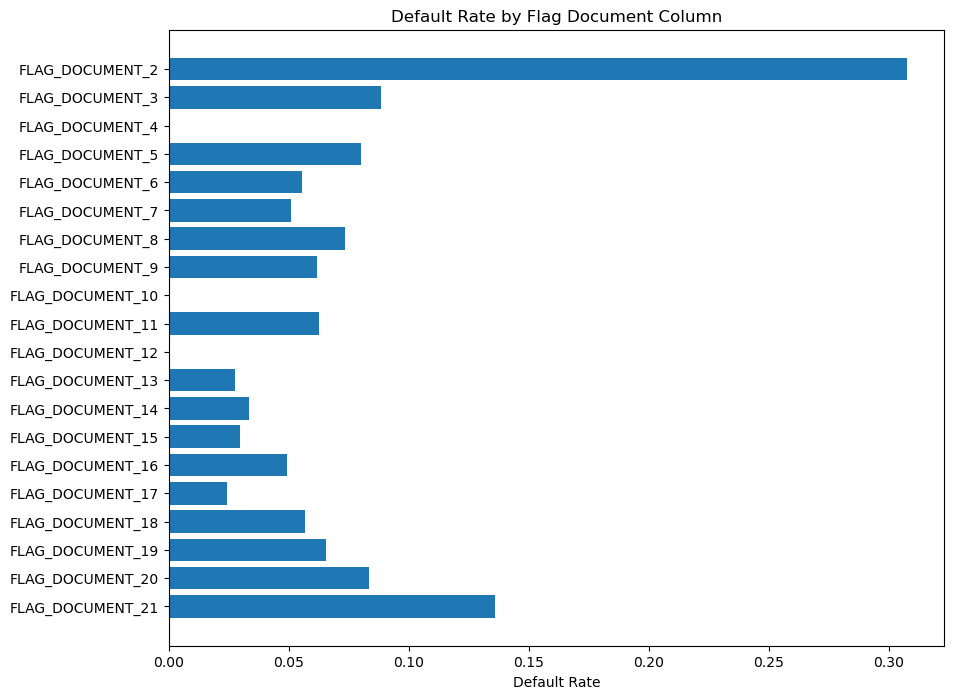

In [95]:

doc_defaults = []
for col in doc_columns:
    doc_defaults.append(int_features.groupby(col)['TARGET'].mean()[1])

fig, ax = plt.subplots(figsize=(10,8))
y_pos = range(len(doc_columns))
ax.barh(y_pos, doc_defaults, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(doc_columns)
ax.invert_yaxis()
ax.set_xlabel('Default Rate')
ax.set_title('Default Rate by Flag Document Column')
plt.show()


In [96]:
important_doc_cols = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3'
                      'FLAG_DOCUMENT_21']

In [97]:
# Drop all document columns that are unimportant
doc_columns = [
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
]

int_features = int_features.drop(doc_columns, axis=1)

#### Children

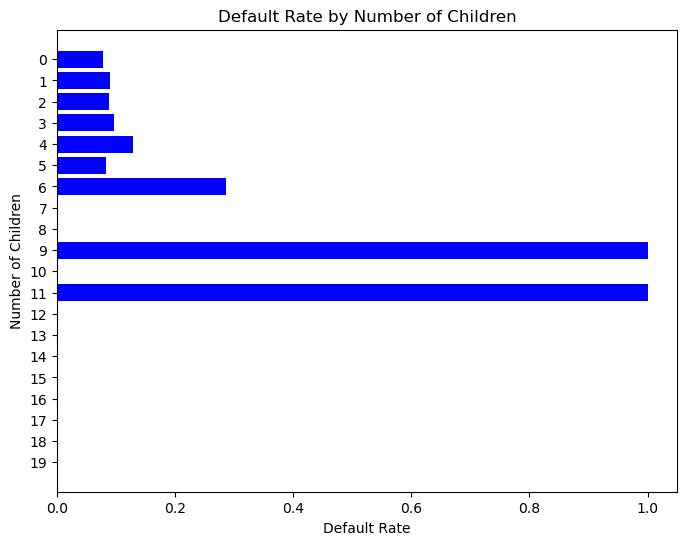

In [98]:
import matplotlib.pyplot as plt

# Calculate default rate for each CNT_CHILDREN value
default_rates = []
for i in range(int_features['CNT_CHILDREN'].max() + 1):
    rate = int_features[int_features['CNT_CHILDREN'] == i]['TARGET'].mean()
    default_rates.append(rate)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(len(default_rates)), default_rates, color='blue')
ax.set_yticks(range(len(default_rates)))
ax.set_yticklabels(range(int_features['CNT_CHILDREN'].max() + 1))
ax.invert_yaxis()
ax.set_xlabel('Default Rate')
ax.set_ylabel('Number of Children')
ax.set_title('Default Rate by Number of Children')
plt.show()


#### Time of day

The 'HOUR_APPR_PROCESS_START' feature describes when the borrower submitted their application. The feature will be binned into morning, day, and night to simplify and guide the model.

In [99]:
int_features['HOUR_APPR_PROCESS_START'] = pd.cut(
    int_features['HOUR_APPR_PROCESS_START'], 
    bins=[0, 8, 16, 24],
    labels=['morning', 'day', 'night']
).astype(str)

In [100]:
int_features = one_hot_encode(int_features, 'HOUR_APPR_PROCESS_START')

In [101]:
# drop everything except for morning
drops = [
    'HOUR_APPR_PROCESS_START_nan',
    'HOUR_APPR_PROCESS_START_night',
    'HOUR_APPR_PROCESS_START_day',
]

int_features = int_features.drop(drops, axis=1)

#### Living/Working Region

In [102]:
int_features['REGIONS_NOT_MATCHED'] = (int_features['REG_REGION_NOT_LIVE_REGION'] + 
                                       int_features['REG_REGION_NOT_WORK_REGION'] + 
                                       int_features['LIVE_REGION_NOT_WORK_REGION'])
int_features = int_features.drop(columns=['REG_REGION_NOT_LIVE_REGION', 
                                           'REG_REGION_NOT_WORK_REGION', 
                                           'LIVE_REGION_NOT_WORK_REGION'])


In [103]:
int_features['CITIES_NOT_MATCHED'] = int_features['REG_CITY_NOT_LIVE_CITY'] + int_features['REG_CITY_NOT_WORK_CITY']
int_features = int_features.drop(columns=['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY'])


In [104]:
int_features['REGION_RATING_CLIENT'].unique()

array([2, 1, 3])

In [105]:

int_features = one_hot_encode(int_features, 'REGION_RATING_CLIENT')


In [106]:
int_features = one_hot_encode(int_features, 'REGION_RATING_CLIENT_W_CITY')

In [107]:
# drop ones and twos from ratings 
drops = [
    'REGION_RATING_CLIENT_1',
    'REGION_RATING_CLIENT_W_CITY_1',
    'REGION_RATING_CLIENT_2',
    'REGION_RATING_CLIENT_W_CITY_2'

]

int_features = int_features.drop(drops, axis=1)

In [108]:
int_features.columns

Index(['TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_21', 'HOUR_APPR_PROCESS_START_morning',
       'REGIONS_NOT_MATCHED', 'CITIES_NOT_MATCHED', 'REGION_RATING_CLIENT_3',
       'REGION_RATING_CLIENT_W_CITY_3'],
      dtype='object')

#### Birthday

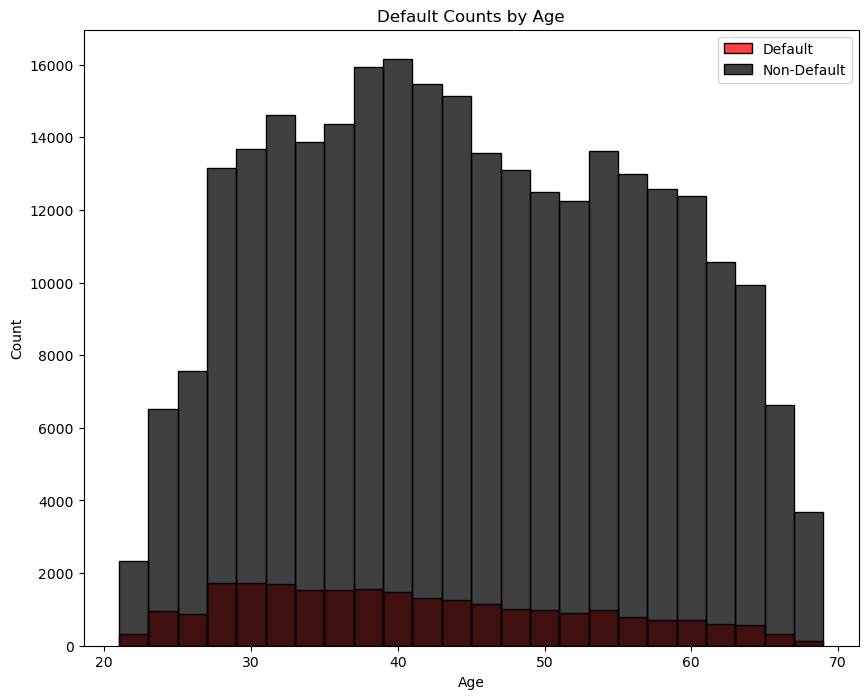

In [109]:
# Convert 'DAYS_BIRTH' to years
int_features['AGE'] = round(-int_features['DAYS_BIRTH'] / 365)

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(
    data=int_features[int_features['TARGET'] == 1], x='AGE', color='red', ax=ax,
    binwidth=2, stat='count', edgecolor='black', linewidth=1.0
)
sns.histplot(
    data=int_features[int_features['TARGET'] == 0], x='AGE', color='black', ax=ax,
    binwidth=2, stat='count', edgecolor='black', linewidth=1.0
)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend(['Default', 'Non-Default'])
plt.title('Default Counts by Age')
plt.show()


In [110]:
int_features['AGE_UNDER_40'] = int_features['DAYS_BIRTH'].apply(lambda x: 1 if x < -40*365 else 0)

Despite creating the 'AGE_UNDER_40' column, we will keep 'DAYS_BIRTH' due to its inherent importance to the model and possibility of contribution to interaction terms or ratios. 

#### All Flag Columns

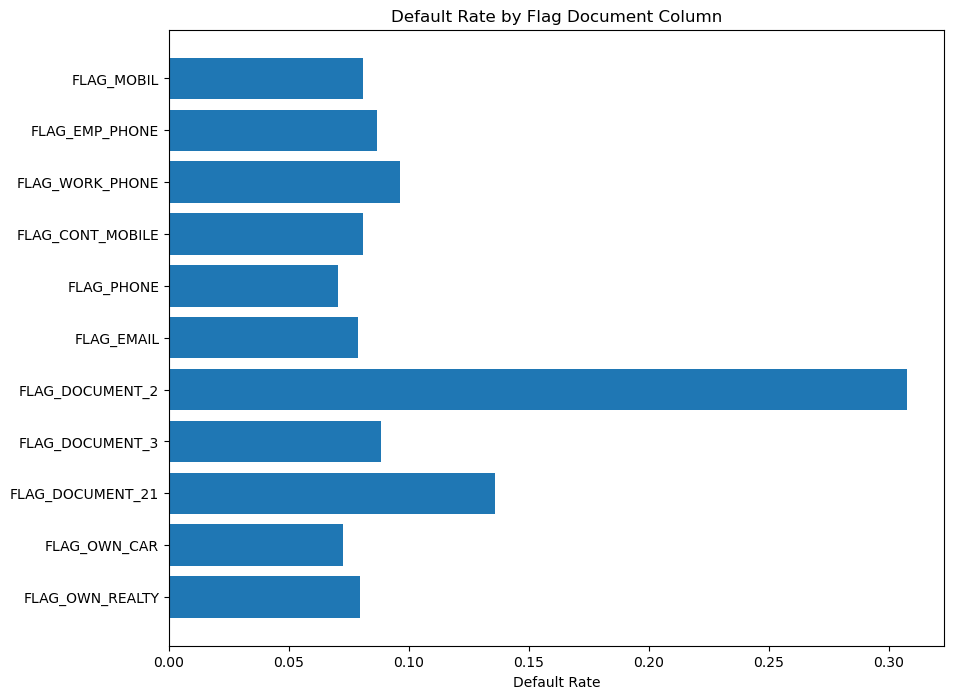

In [111]:
# drop flag columns from obj features and add it to int features
int_features['FLAG_OWN_CAR'] = object_features['FLAG_OWN_CAR']
int_features['FLAG_OWN_REALTY'] = object_features['FLAG_OWN_REALTY']

drops = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
object_features = object_features.drop(drops, axis=1)



flag_cols = int_features.columns[int_features.columns.str.startswith('FLAG_')]

flag_defaults = []
for col in flag_cols:
    flag_defaults.append(int_features.groupby(col)['TARGET'].mean()[1])

fig, ax = plt.subplots(figsize=(10,8))
y_pos = range(len(flag_cols))
ax.barh(y_pos, flag_defaults, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(flag_cols)
ax.invert_yaxis()
ax.set_xlabel('Default Rate')
ax.set_title('Default Rate by Flag Document Column')
plt.show()


In [112]:

int_features['COMMUNICATIONS_FLAGS'] = int_features[
    ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
     'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']].sum(axis=1)

int_features['FLAG_ASSETS'] = int_features[
    ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].sum(axis=1)

int_features = int_features.drop(
    ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 
    'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
    'FLAG_PHONE', 'FLAG_EMAIL', 
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'], axis=1)


### **FLOAT FEATURES**

We will begin by identifying possible imputation strategies for columns with a large number of missing values, or just drop them in general. This is an important first step because the model's predictive power can be disrupted by columns that are not filled with accurate measures of central tendency. 

#### Fill missing values

##### **'AMT_ANNUITY'**

In [113]:

# drop rows with empty annuity value
# very few and misleading data

float_features.dropna(subset=['AMT_ANNUITY'], inplace=True)

##### **'AMT_GOODS_PRICE'**

In [114]:
# same with goods price
# we assume that in a loan application, $ amt for annuity and goods
# will be required

float_features.dropna(subset=['AMT_GOODS_PRICE'], inplace=True)


##### **Columns to fill w/ measures of central tendency**

In [115]:

# define float columns to be imputed
fill_with_mean = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                  'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
fill_with_median = ['CNT_FAM_MEMBERS', 
                    'DAYS_LAST_PHONE_CHANGE']
fill_with_mode = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 
                  'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 
                  'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
# instantiate imputers
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# impute columns with missing values 
float_features[fill_with_mean] = mean_imputer.fit_transform(float_features[fill_with_mean])
float_features[fill_with_median] = median_imputer.fit_transform(float_features[fill_with_median])
float_features[fill_with_mode] = mode_imputer.fit_transform(float_features[fill_with_mode])



##### **EXT_SOURCE Columns**

In [116]:
# loop over the source columns and impute missing values with the mean of the other
# two source columns in the same application

ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

for col in ext_source_cols:
    missing_mask = float_features[col].isnull()
    temp_df = float_features.loc[missing_mask, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
    mean_values = temp_df.mean(axis=1)
    float_features.loc[missing_mask, col] = mean_values

# for columns that have zero external source scores, we will fill them with the mean of the column
float_features[ext_source_cols] = mean_imputer.fit_transform(float_features[ext_source_cols])





##### **Drop columns with too many missing vals**

In [117]:

# define columns to drop
drop = ['OWN_CAR_AGE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 
        'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
        'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 
        'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 
        'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
        'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 
        'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 
        'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 
        'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 
        'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 
        'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
        'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
        'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 
        'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
        'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 
        'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 
        'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 
        'TOTALAREA_MODE']

# drop unimportant columns
float_features = float_features.drop(drop, axis=1)


In [118]:
train = pd.concat([float_features, int_features, object_features], axis=1)

In [119]:
# create new aggregated features out of SOCIAL_CIRCLE_CNT
train['SOCIAL_CIRCLE_CNT'] = train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].sum(axis=1)
train.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)


# sum of inquiries
train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0) + train['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0) + train['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0) + train['AMT_REQ_CREDIT_BUREAU_MON'].fillna(0) + train['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(0) + train['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0)

train = train.drop(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1)

train_preprocessed = train


## **PREVIOUS_APPLICATION.CSV**

In [120]:
prev = pd.read_csv('previous_application.csv')

In [123]:

prev['INTEREST_RATE'] = (prev['AMT_ANNUITY'] * prev['CNT_PAYMENT'] - prev['AMT_CREDIT']) / prev['AMT_CREDIT']
prev['CREDIT_PAYMENTS'] = prev['AMT_CREDIT'] / prev['CNT_PAYMENT']
prev['CREDIT_COST'] = prev['AMT_CREDIT'] + prev['AMT_GOODS_PRICE']

# dictionary of aggregations to be performed
aggregations = {
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_APPLICATION': ['mean', 'max', 'min'],
    'AMT_CREDIT': ['mean', 'max', 'min'],
    'AMT_DOWN_PAYMENT': ['mean', 'max', 'min'],
    'AMT_GOODS_PRICE': ['mean', 'max', 'min'],
    'DAYS_DECISION': ['mean', 'max', 'min'],
    'CNT_PAYMENT': ['mean'],
    'INTEREST_RATE': ['max', 'min'],
    'CREDIT_PAYMENTS': ['mean', 'max', 'min'],
    'CREDIT_COST': ['mean', 'max', 'min']
}


In [124]:
# apply all aggregations to the 'prev' dataset
prev_agg = prev.groupby('SK_ID_CURR').agg(aggregations)

# flatten column names
prev_agg.columns = ['_'.join(col).strip() for col in prev_agg.columns.values]

# Impute missing values with column means
prev_agg.fillna(prev_agg.mean(), inplace=True)


In [125]:
# merge aggregated 'prev' data with 'train'
train_preprocessed['SK_ID_CURR'] = id_curr
train_preprocessed['TARGET'] = target
train_preprocessed = train.merge(prev_agg, on='SK_ID_CURR', how='left')


Dropping the rows with missing values in the aggregation features is seemingly harmless, given that the distribution of the target variable suppresses negative outcomes in these rows. Therefore, we will drop all rows with na values at this point

In [126]:
# check if dataframe has duplicate columns
if len(train_preprocessed.columns) == len(set(train_preprocessed.columns)):
    print("No duplicate columns")
else:
    print("Duplicate columns detected. Removing duplicates...")

    # remove duplicate columns
    train_preprocessed = train_preprocessed.loc[:, ~train_preprocessed.columns.duplicated()]

    # check if duplicate columns were successfully removed
    if len(train_preprocessed.columns) == len(set(train_preprocessed.columns)):
        print("Duplicate columns removed")
    else:
        print("Error: Duplicate columns still present")


Duplicate columns detected. Removing duplicates...
Duplicate columns removed


## **POS_CASH_BALANCE.CSV**

In [127]:
pos_cash = pd.read_csv('POS_CASH_balance.csv')
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [128]:
pos_cash_agg_dict = {
    'MONTHS_BALANCE': ['min', 'max'],
    'CNT_INSTALMENT': ['min', 'max', 'mean'],
    'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}


In [129]:
# groupby SK_ID_CURR and aggregate
pos_cash_grouped = pos_cash.groupby('SK_ID_CURR').agg(
    pos_cash_agg_dict
)

# join with train on SK_ID_CURR
train_preprocessed = train_preprocessed.merge(
    pos_cash_grouped, on='SK_ID_CURR', how='left', suffixes=('','_POS')
)


/var/folders/mq/5ty7rxtj4cj47vsq_y7rgngh0000gn/T/ipykernel_84768/423158198.py:7: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  train_preprocessed = train_preprocessed.merge(


## **FEATURE ENGINNERING**

### **Further EDA**

In [130]:
train = train_preprocessed

In [131]:
# encoded columns are currently titled in tuple form
new_columns = []
for col in train.columns:
    if isinstance(col, tuple):
        new_col = "_".join(str(c) for c in col)
    else:
        new_col = col
    new_columns.append(new_col)

train.columns = new_columns

### **Interaction Features and Ratios**

In [132]:
# ratios

train['CREDIT_TO_ANNUITY'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
train['CREDIT_TO_GOODS'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
train['ANNUITY_INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TO_INCOME'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['GOODS_TO_INCOME'] = train['AMT_GOODS_PRICE'] / train['AMT_INCOME_TOTAL']
train['DAYS_EMPLOYED_TO_BIRTH'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['INCOME_LENGTH'] = train['AMT_INCOME_TOTAL'] / train['DAYS_EMPLOYED']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
train['INCOME_BY_AGE'] = train['AMT_INCOME_TOTAL'] / train['DAYS_BIRTH']
train['EMPLOYMENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['CREDIT_INCOME'] = train['AMT_REQ_CREDIT_BUREAU_TOTAL'] / train['AMT_INCOME_TOTAL']



Creating interaction terms by column multiplicaiton/division, we can capture complex relationships between two inputs that the model wouldn't otherwise pick up on. For example, multiplying the amount of children by the amount of annuity payments may give the model insights into how amount of children can impact a borrowers' ability to make annuity payments on time. 

In [133]:
# create interaction terms between pairs of features
train['INCOME_CREDIT'] = train['AMT_INCOME_TOTAL'] * train['AMT_CREDIT']
train['CREDIT_GOODS'] = train['AMT_CREDIT'] * train['AMT_GOODS_PRICE']
train['EMPLOYED_BIRTH'] = train['DAYS_EMPLOYED'] * train['DAYS_BIRTH']
train['CHILDREN_INCOME'] = train['CNT_CHILDREN'] * train['AMT_INCOME_TOTAL']
train['CHILDREN_CREDIT'] = train['CNT_CHILDREN'] * train['AMT_CREDIT']
train['CHILDREN_ANNUITY'] = train['CNT_CHILDREN'] * train['AMT_ANNUITY']
train['CREDIT_ANNUITY'] = train['AMT_CREDIT'] * train['AMT_ANNUITY']

## **MODEL TRAINING/EVAL**

### **SCALE FEATURES**

In [134]:
# Replace infinite values with NaN
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.dropna(inplace=True)
print(f'Number of Rows: {train.shape[0]}')
print(f'Number of Columns: {train.shape[1]}')

# Separate target and training data
drops = ['TARGET', 'SK_ID_CURR']
preprocessed_target = train['TARGET']
y = preprocessed_target
X = train.drop(drops, axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.75, random_state=81)
print(np.any(np.isnan(Xtrain)))
print(np.any(np.isnan(Xtest)))
print(np.any(np.isinf(Xtrain)))
print(np.any(np.isinf(Xtest)))

# scale to mean 0 std dev 1
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)
Xtrain = pd.DataFrame(Xtrain, columns=X.columns)
Xtest = pd.DataFrame(Xtest, columns=X.columns)

Number of Rows: 193120
Number of Columns: 98
False
False
False
False


### **PCA**

In [135]:
# Reduce dimensionality with PCA
pca = PCA(n_components=60)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)


### **TRAINING**

#### **Random Forest**

In [ ]:
# function that performs randomsearchCV on the RandomForest Classifier
# returns optimal hyperparameters and a list of sorted feature importances

def parameters_and_importances(df, target_col):
    """
    Pass preprocessed training data and target column separately!!!
    """
    print('Beginning Randomized Search Algorithm...')
          
    X = df
    y = target_col
    
    hyperparams = {
        'n_estimators': [50, 100, 150, 200, 400],
        'max_depth': [None, 10, 25, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt'],
        'criterion': ['gini', 'entropy']
    }
    
    rf = RandomForestClassifier(random_state=81)
    
    rf_params = RandomizedSearchCV(estimator=rf, param_distributions=hyperparams,
                                  n_iter=50, cv=5, random_state=81, n_jobs=-1)
    
    rf_params.fit(X, y)
    best = rf_params.best_estimator_
    importances = dict(zip(X.columns, best.feature_importances_))
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_importances, rf_params.best_params_


In [ ]:
# this cell performs a gridsearch for 250 possible hyperparameter configurations
# already ran, do not run again
#importances, params = parameters_and_importances(Xtrain_pca, ytrain)
#print(params)

In [136]:

rf = RandomForestClassifier(
    n_estimators=200, max_depth=3, min_samples_split=2,
    random_state=81, class_weight = {0: 1, 1: 12.5})
rf.fit(Xtrain_pca, ytrain)



Accuracy: 0.6507042253521127
Precision: 0.1365985048372911
Recall: 0.6823174080175728
F1 Score: 0.22762663735458458


#### **XGBoost**

##### Use cross-validation grid search to find optimal hyperparameters

DO NOT RUN !!!!

In [ ]:

xgb_model = XGBClassifier()

# Define the hyperparameter grid
params = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.1, 0.15, 0.2, 0.3, 0.5],
    'scale_pos_weight': [10, 12.5, 15],
    'subsample': [0.75, 1],
    'min_child_weight': [0, 3, 5],
    'gamma': [0, 0.1, 0.25, 0.5]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    n_iter=100,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    verbose=3
)

#random_search.fit(Xtrain_pca, ytrain)
#best_params = random_search.best_params_
#print(best_params)


##### Train

In [137]:
# Fit an XGBoost model to the resampled training data
# scale_pos_weight set to 12.5, positive class represents ~ 8% of data.

xgb = XGBClassifier(
    n_estimators=200, max_depth=3, learning_rate=0.1, scale_pos_weight=12.5, gamma = 0.1,
    min_child_weight=3, subsample=0.75
)
xgb.fit(Xtrain_pca, ytrain)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Evaluation Metrics

In [151]:
y_pred_rf = rf.predict(Xtest_pca)
y_prob_rf = rf.predict_proba(Xtest_pca)[:, 1]
rf_accuracy = accuracy_score(ytest, y_pred_rf)
rf_precision = precision_score(ytest, y_pred_rf)
rf_recall = recall_score(ytest, y_pred_rf)
rf_f1 = f1_score(ytest, y_pred_rf)
print("Random Forest Results:")
print('-'*50)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)


Random Forest Results:
--------------------------------------------------
Accuracy: 0.6507042253521127
Precision: 0.1365985048372911
Recall: 0.6823174080175728


In [152]:
y_pred = xgb.predict(Xtest_pca)
y_prob = xgb.predict_proba(Xtest_pca)[:, 1]
xgb_accuracy = accuracy_score(ytest, y_pred)
xgb_precision = precision_score(ytest, y_pred)
xgb_recall = recall_score(ytest, y_pred)
print('XGBoost Results:')
print('-'*50)
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)


XGBoost Results:
--------------------------------------------------
Accuracy: 0.7052195526097763
Precision: 0.15754753589445092
Recall: 0.6688632619439868


In [140]:
def plot_classification_results(ytest, y_pred, y_prob):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion matrix heatmap
    cm = confusion_matrix(ytest, y_pred)
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Greens', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color="Green", lw=2, label="ROC curve (area = %0.4f)" % roc_auc)
    ax2.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
    ax2.fill_between(fpr, tpr, color="Lightgreen", alpha=0.5)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.0])
    ax2.set_xlabel("FPR")
    ax2.set_ylabel("TPR")
    ax2.set_title("Receiver Operating Characteristic")
    ax2.legend(loc="lower right")

    plt.show()


RESULTS FOR RANDOM FOREST CLASSIFIER


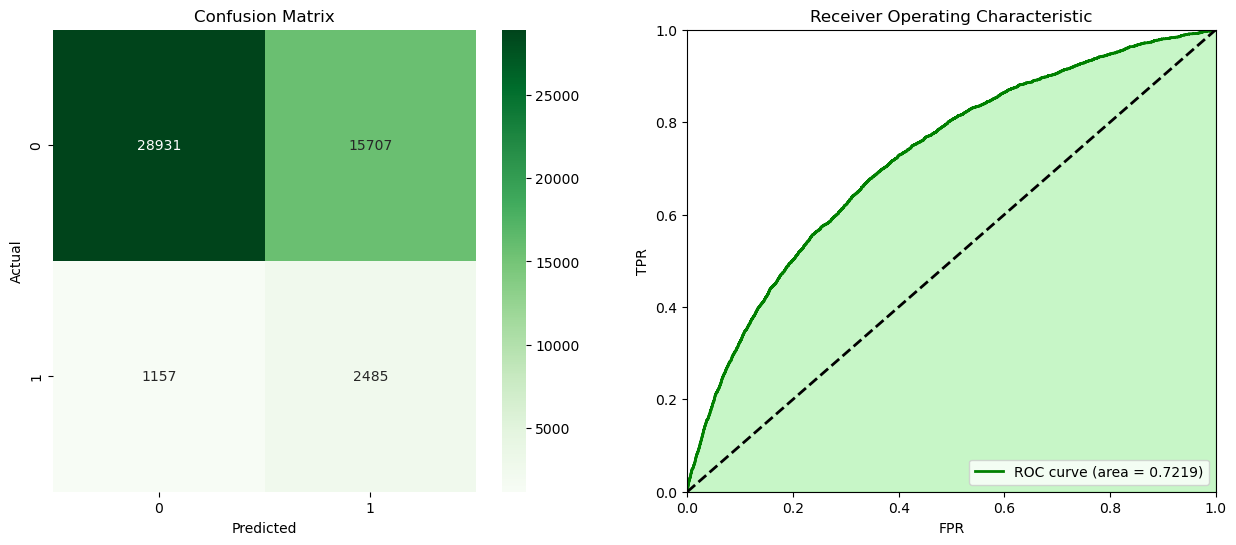

In [150]:

# plots of results for the Random Forest Classifier
print("RESULTS FOR RANDOM FOREST CLASSIFIER")
plot_classification_results(ytest, y_pred_rf, y_prob_rf)

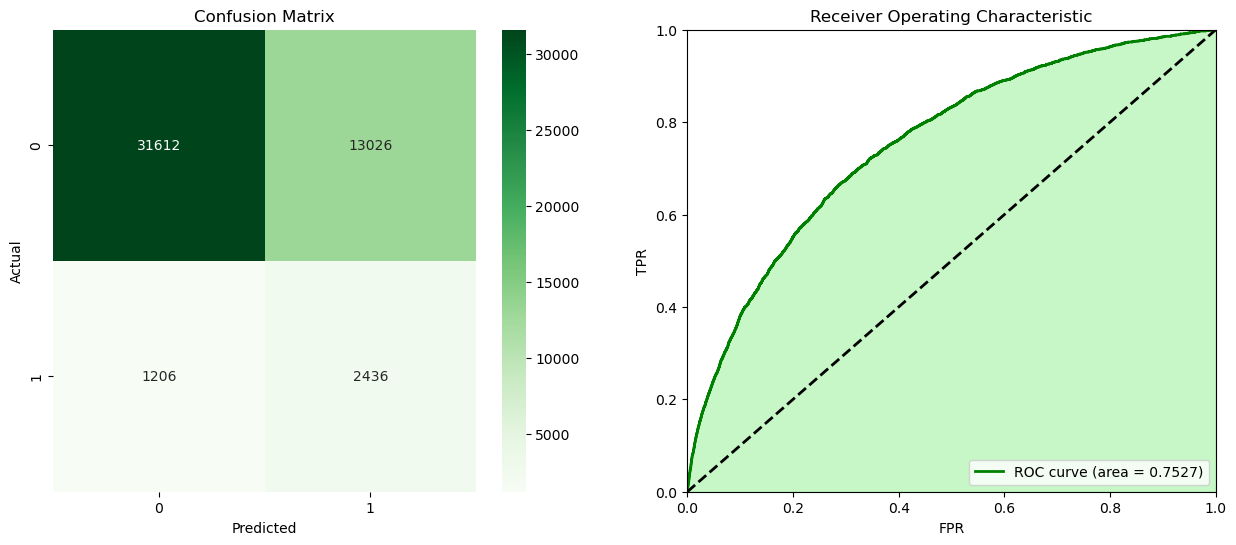

In [144]:

# plots of results for XGBoost model

plot_classification_results(ytest, y_pred, y_prob)